In [1]:
# Something is wrong with jupyterlabs execution path
import os
os.chdir(os.path.dirname(os.path.abspath(".")))

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
from ConvLSTM import Seq2Seq
from DatasetOperations import SLADataset, Loss, DatasetParameters
import TrainingLoop
import SaveLoadModels

import tabulate
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

import xarray as xr
from datetime import date
from pathlib import Path
from typing import Type
import matplotlib.pyplot as plt
from IPython import display

try:
    from ..Models import _types
except:
    from Models import _types

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print(f"Using: 'cuda:{torch.cuda.current_device()}'")
else:
    print("Using: cpu")
    DEVICE = torch.device("cpu")

BASEPATH = Path(r"Data/Grids/")
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using: 'cuda:0'


# Hyperparameters

In [3]:
dataset_parameters = DatasetParameters(
    batch_size = 5,
    sequence_length = 3,
    sequence_steps = 5,
    prediction_steps = 30,
    fill_nan = 99,
    train_end = date(2014, 1, 1),
    validation_end = date(2019, 1, 1)
)

# Setup data

In [4]:
with xr.open_dataset(BASEPATH / "without_polar_v5_mss21.nc", engine="netcdf4") as file:
    file = file.sortby('time')
    sla = file['sla21'].data
    times = file['time'].data
    lat = file['Latitude'].data
    lon = file['Longitude'].data

In [5]:
train_end = np.array(dataset_parameters.train_end).astype("datetime64[ns]")
validation_end = np.array(dataset_parameters.validation_end).astype("datetime64[ns]")

# Save times
bool_train = times <= train_end
bool_validation = (times > train_end) & (times <= validation_end)
bool_test = times > validation_end

train_time = times[bool_train].astype("datetime64[D]").astype(int)
validation_time = times[bool_validation].astype("datetime64[D]").astype(int)
test_time = times[bool_test].astype("datetime64[D]").astype(int)

# Save sla features
train_features = sla[bool_train]
validation_features = sla[bool_validation]
test_features = sla[bool_train]

In [6]:
# Kwargs to dataloaders
kwargs_dataloader = {
    'shuffle': False,
    'batch_size': dataset_parameters.batch_size
}

# Dataloders
train_loader = DataLoader(SLADataset(train_features, train_time, dataset_parameters), **kwargs_dataloader)
validation_loader = DataLoader(SLADataset(validation_features, validation_time, dataset_parameters), **kwargs_dataloader)
test_loader = DataLoader(SLADataset(test_features, test_time, dataset_parameters), **kwargs_dataloader)

# Get a batch
input_features, result, result_mask, time_features, result_time = next(iter(train_loader))

# Set frame size
frame_size = tuple(input_features.shape[-2:])

## Datasizes

In [7]:
tabulate.tabulate(
    [
        ["Sizes" ,"batch_size", "num_channels", "sequence length", "y_size", "x_size"],
        ["Input", *input_features.shape],
        ["Output", *result.shape[:1], None, None, *result.shape[1:]],
        ["Mask", *result_mask.shape[:1], None, None, *result_mask.shape[1:]]
    ],
    tablefmt='html'
)

Sizes,batch_size,num_channels,sequence length,y_size,x_size
Input,5,1,3,129,360
Output,5,,,129,360
Mask,5,,,129,360


# Loss function

In [8]:
def create_masked_loss_function(loss_module: Type[nn.modules.loss._Loss]) -> TrainingLoop.loss_function:
    """Constructs a masked loss function based on the loss module"""
    loss_function = loss_module()
    def masked_loss_function(output: torch.Tensor, target: torch.Tensor, masked: torch.Tensor) -> torch.Tensor:
        """
        Maskes the output and target based on the mask.
        The mask is True where the values should be ignored.
        """
        masked_output = output[~masked]
        masked_target = target[~masked]
        return loss_function(masked_output, masked_target)
    return masked_loss_function

In [9]:
criterion = create_masked_loss_function(nn.MSELoss)

# Set model parameters

In [10]:
def print_on_epoch(loss: Loss):
    rms_train = np.sqrt(loss.training)*100
    rms_val = np.sqrt(loss.validation)*100
    print(f"Epoch: {loss.epoch} Training Loss: {rms_train:.2f} cm Validation Loss: {rms_val:.2f} cm")

def setup_plot_on_epoch():
    epochs = []
    train = []
    val = []
    
    def update_line(loss: Loss):
        rms_train = np.sqrt(loss.training)*100
        rms_val = np.sqrt(loss.validation)*100
        epochs.append(loss.epoch)
        train.append(rms_train)
        val.append(rms_val)
        plt.plot(epochs, train, color='red', label="Training")
        plt.plot(epochs, val, color='blue', label="Validation")
        if len(epochs) == 1:
            plt.title("Loss")
            plt.legend(loc='upper right')
            plt.xlabel("Epoch")
            plt.ylabel("RMSE SLA [cm]")
            plt.grid()
        display.display(plt.gcf())
        display.clear_output(wait=True)
    return update_line

In [11]:
learning_rate = 1e-4
epochs = 2

# Setup model and train model

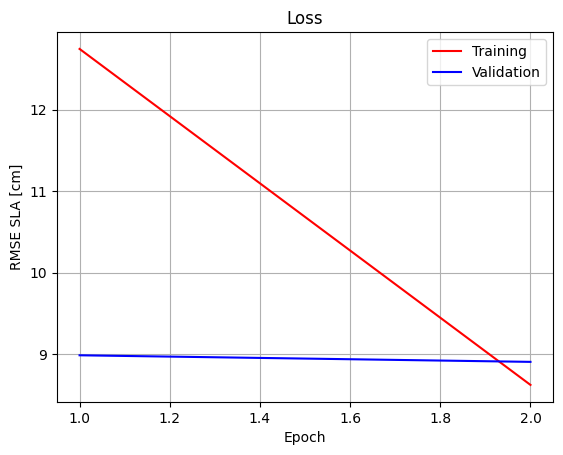

In [12]:
model = Seq2Seq(
    num_channels = 1,
    num_kernels = 32,
    kernel_size = (3, 3),
    padding = (1, 1),
    activation = nn.ReLU(), 
    frame_size = frame_size,
    num_layers = 2,
    device = DEVICE
).to(DEVICE)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
model.train()
# Train model
losses = TrainingLoop.train_validation_loop(
    model,
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    epochs,
    DEVICE,
    setup_plot_on_epoch(),
    Path("SavedModels", "test"),
    2,
    dataset_parameters,
)

# Inference

In [13]:
# Make predictions
loader = validation_loader
outputs, targets, target_times = TrainingLoop.predict(model, loader, frame_size, DEVICE)
target_times = (np.array([0], dtype="datetime64[ns]") + target_times.astype("timedelta64[D]")).astype("datetime64[D]")

In [14]:
extent = [lon[0].min() - 0.5, lon[0].max() + 0.5, lat[:,0].min() - 0.5, lat[:,0].max() + 0.5]

## One sample comparisions

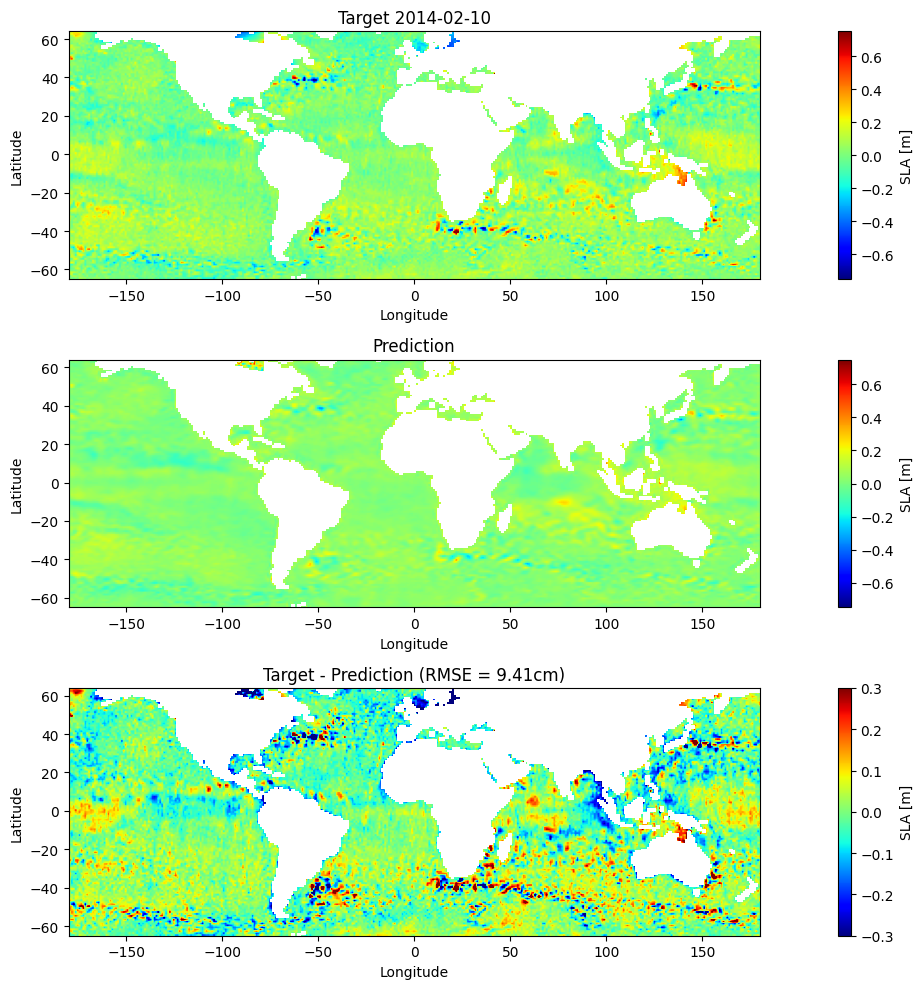

In [15]:
idx = 0
vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diff_data = targets[idx] - outputs[idx]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(targets[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(outputs[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx]}")
axes[1].set_title("Prediction")
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()

## RMSE average temporal

In [16]:
diffs: _types.float_like = targets - outputs
rmses = np.full(diffs.shape[1:], np.nan)
for lat_idx in range(targets.shape[1]):
    for lon_idx in range(targets.shape[2]):
        pixel_diffs = diffs[:, lat_idx, lon_idx]
        pixel_diffs_nonan = pixel_diffs[~np.isnan(pixel_diffs)]
        if len(pixel_diffs_nonan) == 0:
            continue
        rmses[lat_idx, lon_idx] = np.sqrt(pixel_diffs_nonan @ pixel_diffs_nonan/len(pixel_diffs_nonan))

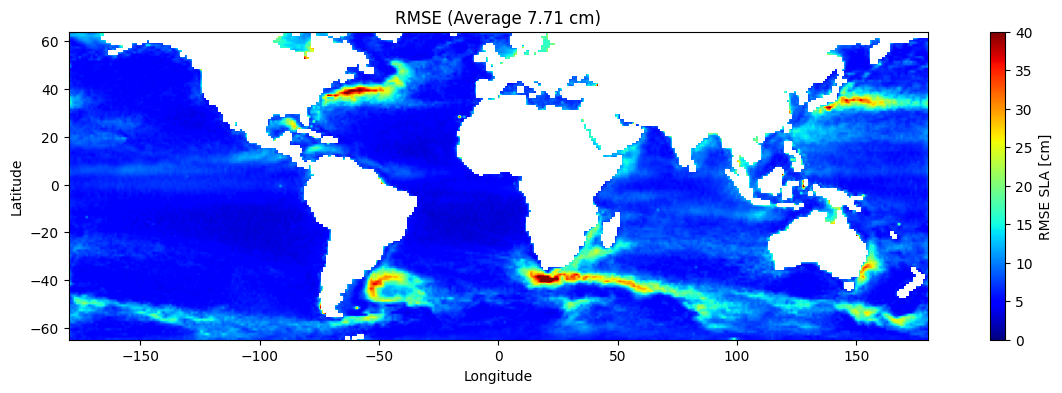

In [17]:
vmin = 0
vmax = 40
cmap = 'jet'

fig, ax = plt.subplots(1, 1, figsize=(16,4))
im_rms = ax.imshow(rmses * 100, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_title(f"RMSE (Average {np.nanmean(rmses)*100:.2f} cm)")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
cax = fig.colorbar(im_rms)
cax.ax.set_ylabel("RMSE SLA [cm]")
plt.show()